In [20]:
# Read the 23andMe raw data file and turn it into a dataframe
import pandas as pd
import numpy as np
import sys

ExampleData = "../../Data/23andMe_files/genome_Chad_Wrye_v5_Full_20220921063742.txt"

# Read the text file into a DataFrame
ttAndMe = pd.read_csv(ExampleData, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

# Find all the positions in ttAndMe that are in PRS313 by identifying columns with the same position and chromosome
PRS313 = pd.read_excel('../../Data/PRS313.xlsx')

PRS313['in_23andMe'] = PRS313.apply(lambda x: ttAndMe[(ttAndMe['position'] == x['Positionb']) & (ttAndMe['chromosome'] == x['Chromosome'])].shape[0] > 0, axis=1)

PRS313[(PRS313['in_23andMe'] == True) & (PRS313["Chromosome"] == 1)]

PRS313.to_excel('../../Data/PRS313_with_23andMe.xlsx', index=False)

PRS313

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/378530466.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(ExampleData, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


,SNPa,Chromosome,Positionb,Reference Allele,Effect Allele,EAFc,Overall Breast Cancerd,ER-positivee,ER-negativef,hybrid ER-positiveg,hybrid ER-negativeh,in_23andMe,rsid
0,1_100880328_A_T,1,100880328,A,T,0.409678,0.0373,0.0355,0.0160,0.0373,0.0373,False,NaN
1,1_10566215_A_G,1,10566215,A,G,0.329016,-0.0586,-0.0407,-0.1109,-0.0407,-0.1109,True,rs616488
2,1_110198129_CAAA_C,1,110198129,CAAA,C,0.775478,0.0458,0.0545,0.0266,0.0458,0.0458,False,NaN
3,1_114445880_G_A,1,114445880,G,A,0.166363,0.0621,0.0642,0.0579,0.0621,0.0621,False,NaN
4,1_118141492_A_C,1,118141492,A,C,0.265682,0.0452,0.0417,0.0551,0.0452,0.0452,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,22_39343916_T_A,22,39343916,T,A,0.254083,0.0407,0.0326,0.0330,0.0407,0.0407,False,NaN
309,22_40904707_CT_C,22,40904707,CT,C,0.109871,0.1148,0.1160,0.1203,0.1148,0.1148,False,NaN
310,22_43433100_C_T,22,43433100,C,T,0.114445,-0.0600,-0.0585,-0.0515,-0.0600,-0.0600,False,NaN
311,22_45319953_G_A,22,45319953,G,A,0.416619,-0.0134,-0.0060,-0.0611,-0.0060,-0.0611,False,NaN


In [65]:
import os
import pandas as pd

# Set the path to the folder containing the 23andMe files
folder_path = "../../Data/23andMe_files"

# Read the PRS313 file
PRS313 = pd.read_excel('../../Data/PRS313.xlsx')

# Initialize a dictionary to store the results
result_dict = {}

# Initialize a set to store the unique positions from all 23andMe files
unique_positions_set = set()

# Initialize a dictionary to store the counts of positions from each 23andMe file
position_counts = {}

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        # Read the 23andMe raw data file into a DataFrame
        ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

        # If the number of positions is greater than 700000 or less than 600000, delete the file and move on
        if ttAndMe.shape[0] > 700000 or ttAndMe.shape[0] < 600000:
            print(f"File {filename} has an invalid number of positions: {ttAndMe.shape[0]}. Deleting the file.")
            os.remove(file_path)
            continue

        # Merge the 23andMe DataFrame with the PRS313 DataFrame based on chromosome and position
        merged_df = pd.merge(ttAndMe, PRS313[['SNPa', 'Chromosome', 'Positionb']], left_on=['chromosome', 'position'], right_on=['Chromosome', 'Positionb'], how='inner')

        # Count the presence of each SNP in the merged DataFrame
        snp_presence = merged_df.groupby('SNPa').size().reindex(PRS313['SNPa'], fill_value=0).astype(bool)

        # Count the total number of SNPs present
        total_snps_present = snp_presence.sum()

        # Count the total number of positions in the 23andMe file
        total_positions = ttAndMe.shape[0]

        # Store the results in the dictionary
        result_dict[filename] = list(snp_presence) + [total_snps_present, total_positions]

        # Update the unique positions set
        unique_positions_set.update(zip(ttAndMe['chromosome'], ttAndMe['position']))

        # Update the position counts dictionary
        for pos in zip(ttAndMe['chromosome'], ttAndMe['position']):
            position_counts[pos] = position_counts.get(pos, 0) + 1

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        os.remove(file_path)
        continue

# Create the result DataFrame from the dictionary
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=PRS313['SNPa'].tolist() + ['total_snps_present', 'total_positions'])


# Save the results to Excel files
result_df.to_excel('../../Data/PRS313_23andMe_PRS313_intersection.xlsx', index_label='filename')




/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11854.23andme.9737.txt: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11822.23andme.9707.txt: 'utf-8' codec can't decode byte 0xc7 in position 10: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 12224.23andme.10069.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 12169.23andme.10018.txt: Error tokenizing data. C error: Expected 4 fields in line 618632, saw 5



/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 12283.23andme.10117.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11800.23andme.9694.txt: 'utf-8' codec can't decode byte 0xec in position 15: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11601.23andme.9497.txt: 'utf-8' codec can't decode byte 0x8f in position 10: invalid start byte
Error processing file 12330.23andme.10166.txt: 'utf-8' codec can't decode byte 0xff in position 15: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11869.23andme.9748.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11666.23andme.9588.txt: 'utf-8' codec can't decode byte 0xba in position 11: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 12335.23andme.10172.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 12130.23andme.9985.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 12223.23andme.10068.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11602.23andme.9498.txt: 'utf-8' codec can't decode byte 0x9c in position 11: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11789.23andme.9685.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 12203.23andme.10052.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11615.23andme.9528.txt: 'utf-8' codec can't decode byte 0xbd in position 10: invalid start byte
Error processing file 11736.23andme.9639.txt: 'utf-8' codec can't decode byte 0xb2 in position 10: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11725.23andme.9634.txt: 'utf-8' codec can't decode byte 0xb2 in position 10: invalid start byte
Error processing file 11615.23andme.9529.txt: 'utf-8' codec can't decode byte 0xbd in position 10: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 12373.23andme.10203.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11619.23andme.9534.txt: 'utf-8' codec can't decode byte 0xe1 in position 10: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11629.23andme.9550.txt: 'utf-8' codec can't decode byte 0x95 in position 11: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11619.23andme.9535.txt: 'utf-8' codec can't decode byte 0xe1 in position 10: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11792.23andme.9691.txt: 'utf-8' codec can't decode byte 0xfb in position 10: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11725.23andme.9633.txt: 'utf-8' codec can't decode byte 0xb2 in position 10: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11834.23andme.9714.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11692.23andme.9607.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11826.23andme.9708.txt: 'utf-8' codec can't decode byte 0x8e in position 10: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11613.23andme.9536.txt: 'utf-8' codec can't decode byte 0xad in position 11: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11613.23andme.9537.txt: 'utf-8' codec can't decode byte 0xad in position 11: invalid start byte
Error processing file 9921.23andme.10110.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

Error processing file 11677.23andme.9594.txt: 'utf-8' codec can't decode byte 0xd0 in position 10: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 11617.23andme.9531.txt: 'utf-8' codec can't decode byte 0xf4 in position 10: invalid continuation byte
Error processing file 11617.23andme.9530.txt: 'utf-8' codec can't decode byte 0xf4 in position 10: invalid continuation byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])


Error processing file 12191.23andme.10038.txt: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_57645/4104968455.

In [71]:
output_folder = "../../Data/23andMe_metadata_files/"

os.makedirs(output_folder, exist_ok=True)

# Create a DataFrame with unique positions
unique_positions_df = pd.DataFrame(list(unique_positions_set), columns=['chromosome', 'position'])
unique_positions_df = unique_positions_df.astype(str)

unique_positions_df.to_parquet(f'{output_folder}23andMe_unique_positions.parquet', index=False)

# Find the positions present in all 23andMe files
num_files = len(result_dict)
intersection_positions_100 = [pos for pos, count in position_counts.items() if count == num_files]
intersection_positions_95 = [pos for pos, count in position_counts.items() if count > 0.95 * num_files]
intersection_positions_90 = [pos for pos, count in position_counts.items() if count > 0.9 * num_files]
intersection_positions_85 = [pos for pos, count in position_counts.items() if count > 0.85 * num_files]
intersection_positions_80 = [pos for pos, count in position_counts.items() if count > 0.8 * num_files]
intersection_positions_75 = [pos for pos, count in position_counts.items() if count > 0.75 * num_files]
intersection_positions_70 = [pos for pos, count in position_counts.items() if count > 0.7 * num_files]
intersection_positions_65 = [pos for pos, count in position_counts.items() if count > 0.65 * num_files]
intersection_positions_60 = [pos for pos, count in position_counts.items() if count > 0.65 * num_files]


intersection_positions_df_100 = pd.DataFrame(intersection_positions_100, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_95 = pd.DataFrame(intersection_positions_95, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_90 = pd.DataFrame(intersection_positions_90, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_85 = pd.DataFrame(intersection_positions_85, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_80 = pd.DataFrame(intersection_positions_80, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_75 = pd.DataFrame(intersection_positions_75, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_70 = pd.DataFrame(intersection_positions_70, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_65 = pd.DataFrame(intersection_positions_65, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_60 = pd.DataFrame(intersection_positions_60, columns=['chromosome', 'position']).astype(str)

# Save the intersection positions to Excel files

intersection_positions_df_100.to_parquet(f'{output_folder}23andMe_intersection_positions_100.parquet', index=False)
intersection_positions_df_95.to_parquet(f'{output_folder}23andMe_intersection_positions_95.parquet', index=False)
intersection_positions_df_90.to_parquet(f'{output_folder}23andMe_intersection_positions_90.parquet', index=False)
intersection_positions_df_85.to_parquet(f'{output_folder}23andMe_intersection_positions_85.parquet', index=False)
intersection_positions_df_80.to_parquet(f'{output_folder}23andMe_intersection_positions_80.parquet', index=False)
intersection_positions_df_75.to_parquet(f'{output_folder}23andMe_intersection_positions_75.parquet', index=False)
intersection_positions_df_70.to_parquet(f'{output_folder}23andMe_intersection_positions_70.parquet', index=False)
intersection_positions_df_65.to_parquet(f'{output_folder}23andMe_intersection_positions_65.parquet', index=False)
intersection_positions_df_60.to_parquet(f'{output_folder}23andMe_intersection_positions_60.parquet', index=False)


In [76]:
intersection_positions_df_80.to_csv(f'{output_folder}23andMe_intersection_positions_80.tsv', index=False, sep='\t')


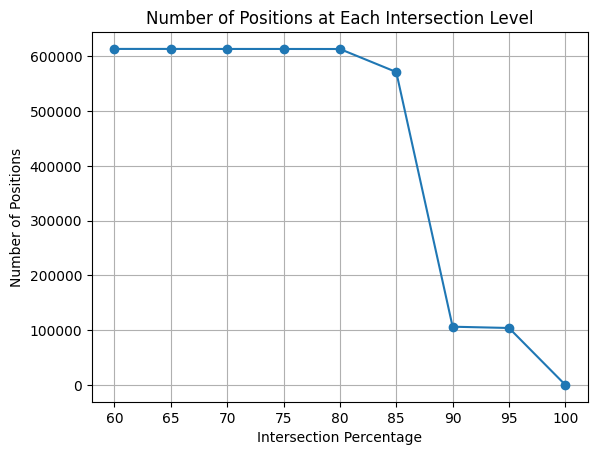

In [72]:
# Graph the number of positions at each intersection level. Plot every 5% from 60% to 100%
import matplotlib.pyplot as plt

intersection_percentages = [60, 65, 70, 75, 80, 85, 90, 95, 100]
intersection_counts = [intersection_positions_df_60.shape[0], intersection_positions_df_65.shape[0], intersection_positions_df_70.shape[0], intersection_positions_df_75.shape[0],
                       intersection_positions_df_80.shape[0], intersection_positions_df_85.shape[0], intersection_positions_df_90.shape[0], intersection_positions_df_95.shape[0], intersection_positions_df_100.shape[0]]

plt.plot(intersection_percentages, intersection_counts, marker='o')
plt.xlabel('Intersection Percentage')
plt.ylabel('Number of Positions')
plt.title('Number of Positions at Each Intersection Level')
plt.grid()
plt.show()

In [73]:
print("Number of unique positions in all 23andMe files:", len(unique_positions_set))

Number of unique positions in all 23andMe files: 3315258


# Convert all the 23andMe files to text files

In [36]:
# Set the path to the folder containing the 23andMe files
folder_path = "../../Data/23andMe_files"

# Convert all the 23andMe files to .txt format if they are not already in that format

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Check if the file is already in .txt format
    if not filename.endswith('.txt'):
        new_file_path = os.path.join(folder_path, filename + '.txt')
        os.rename(file_path, new_file_path)
        print(f"Renamed {filename} to {filename.split('.')[0] + '.txt'}")
        

Renamed 12102.23andme.9966 to 12102.txt
Renamed 11864.23andme.9744 to 11864.txt
Renamed 11826.23andme.9708 to 11826.txt
Renamed 11703.23andme.9619 to 11703.txt
Renamed 12065.23andme.9923 to 12065.txt
Renamed 11936.23andme.9808 to 11936.txt
Renamed 12299.23andme.10131 to 12299.txt
Renamed 11874.23andme.9752 to 11874.txt
Renamed 12072.23andme.9932 to 12072.txt
Renamed 11662.23andme.9585 to 11662.txt
Renamed 12192.23andme.10043 to 12192.txt
Renamed 11983.23andme.9848 to 11983.txt
Renamed 11775.23andme.9673 to 11775.txt
Renamed 11919.23andme.9794 to 11919.txt
Renamed 11850.23andme.9730 to 11850.txt
Renamed 11765.23andme.9663 to 11765.txt
Renamed 12266.23andme.10102 to 12266.txt
Renamed 12155.23andme.10004 to 12155.txt
Renamed 10936.23andme.9481 to 10936.txt
Renamed 11993.23andme.9860 to 11993.txt
Renamed 12018.23andme.9881 to 12018.txt
Renamed 11919.23andme.9793 to 11919.txt
Renamed 11957.23andme.9826 to 11957.txt
Renamed 11722.23andme.9630 to 11722.txt
Renamed 11654.23andme.9576 to 11654.

In [35]:
# Print number of files in the folder
len(os.listdir(folder_path))


279